# Inference Speedup

## Подготовка


In [1]:
import time
from typing import List
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import triton
import triton.language as tl

print("torch version:", torch.__version__)
print("triton version:", triton.__version__)

from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

torch version: 2.6.0+cu124
triton version: 3.2.0


### Catch activation ans weight

In [2]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [3]:
# challenging input
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

In [4]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generation_output = model.generate(**model_inputs, streamer=streamer, max_new_tokens=1024)

To achieve the described functionality, we need to follow several steps:

1. Parse the JSON data.
2. Create a Google Sheets client using the `google-auth` library.
3. Read existing data from the Google Sheet.
4. Determine the month from the provided date.
5. Organize and format the data to be written into the Google Sheet.
6. Insert the data into the appropriate columns.
7. Sort the expenses and revenues by date.
8. Save the changes to the Google Sheet.

Let's break this down into steps and write the corresponding code.

### Step-by-Step Code Implementation

```python
import json
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

# Load JSON data
json_data = '''
{
    "date": "31-05-2024",
    "revenue": 90000,
    "person": "User1",
    "expensesList": [30000, 14000, 10000, 2000, 15000],
    "expensesDescList": ["Ключи", "Ключи2", "Счет за такси", "Клей, пластины", "Провод 40м"],
    "expensesTypeList": ["Закупки", "Закупки", "Расходы", 

In [5]:
class Catcher(nn.Module):
    def __init__(self, inps: List, module: nn.Module):
        super().__init__()
        self.module = module
        self.inps = inps

    def forward(self, inp, **kwargs):
        self.inps.append(inp.to("cpu"))
        raise ValueError

In [6]:
layer = model.model.layers[0]
inps = []
layer.self_attn.q_proj = Catcher(inps, layer.self_attn.q_proj) # wrap

In [7]:
try:
    model(model_inputs.input_ids)
except ValueError as e:
    layer.self_attn.q_proj = layer.self_attn.q_proj.module

In [8]:
inps[0].shape

torch.Size([1, 700, 2048])

In [9]:
weight = layer.self_attn.q_proj.weight # unwrap

In [10]:
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

assert is_cuda(), "CUDA only tutorial"
ref_lib = 'cuBLAS'

In [11]:
def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),

        # custom
        # !!! TASK: add some tilings for decode scenario
        # hint: BLOCK_SIZE_M should be small
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")

## Задача

### Dynamic W8A8 GeMM

> **Важный дисклеймер:** пожалуйста, выполняйте задачу к google colab на среде T4, потому что на ней эта задача оттестирована и уже установлены правильные зависимости по умолчанию, это сэкономит вам кучу времени.

Для непослушных: на другом типе видеокарт (H100) код придется сильно переписывать, чтобы учесть архитектурные особенности для максимальной производительности (см. "менее полезное, но интересное" выше в семинаре).

> **Важный дисклеймер 2:** для выполнения задачи нужно запустить код выше, в нем есть нужные helper функции.

Useful resources:
- [Matrix Multiplication Background User's Guide](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html)
- [Deep Dive on CUTLASS Ping-Pong GEMM Kernel](https://pytorch.org/blog/cutlass-ping-pong-gemm-kernel/)
- [Accelerating 2D Dynamic Block Quantized Float8 GEMMs in Triton](https://pytorch.org/blog/accelerating-gemms-triton/)

![](https://habrastorage.org/webt/xq/r5/8a/xqr58aw0gd6tdm-j45yqad67w1a.png)

В этом задании вам нужно будет реализовать быструю операцию квантизации в per-row режиме:
1. Для этого нужно опять же заполнить пропуски возле `YOUR CODE HERE`, пожалуйста не удаляйте эти комментарии с заданием и обозначением, это облегчает проверку
2. Рядом с каждым пропуском есть комментарий с `# !!! TASK: ...`, который поможет разобраться что именно нужно написать
3. На иллюстрации выше как раз показано по каким именно размерностям для матриц активаций и весов считаются scales
4. Формула для `scales = tensor.abs().max(axis=axis) / INT8_max_value`

In [12]:
@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
     ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
    fpa_ptr, a_ptr, as_ptr,
    M, K,
    stride_fpam, stride_fpak,
    stride_am, stride_ak,
    stride_asm,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid_m = tl.program_id(axis=0)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak
    a_max = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)

        # calc maximum absolute value of each row of fpa and update a_max
        row_max = tl.max(tl.abs(fpa.to(tl.float32)), axis=1)
        a_max = tl.maximum(a_max, row_max)


        fpa_ptrs += BLOCK_SIZE_K * stride_fpak

    # divide a_max by max positive INT8 value
    a_max = tl.maximum(a_max, 1e-8)  # защита от нуля
    a_scale = a_max / 127.0

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)

        # divide fpa by a_scale and convert to INT8
        inta = (fpa.to(tl.float32) / a_scale[:, None]).to(tl.int8)

        tl.store(a_ptrs, inta, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K)
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
        a_ptrs += BLOCK_SIZE_K * stride_ak
    as_offs = pid_m * BLOCK_SIZE_M * stride_asm + tl.arange(0, BLOCK_SIZE_M)
    tl.store(as_ptr + as_offs, a_scale)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale


def quantize_int8(weight, axis=0, tp_rank=0):
    # Weight shape: [H1, H2]
    # Scale shape: [H2]

    # calculate scale by taking maximum over axis and saving dims and divide on maximum positive INT8 value
    INT8_MAX = 127.0
    scale = weight.abs().amax(dim=axis, keepdim=True)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)
    scale = scale / INT8_MAX

    # divide weight by scale and convert to int8
    quant = (weight / scale).round()
    quant = torch.clamp(quant, -128, 127).to(torch.int8)
    weight = quant

    # col major will accelerate i8xi8 kernel.
    if axis == 0:
        weight = weight.t().contiguous().t()
    scale = scale.squeeze(axis)
    return weight.contiguous().cuda(tp_rank), scale.contiguous().cuda(tp_rank)


Далее нам предстоит реализовать уже быструю операцию для per-row W8A8 GeMM:
1. Для этого нужно опять же заполнить пропуски возле `YOUR CODE HERE`, пожалуйста не удаляйте эти комментарии с заданием и обозначением, это облегчает проверку
2. Рядом с каждым пропуском есть комментарий с `# !!! TASK: ...`, который поможет разобраться что именно нужно написать

In [13]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def perrow_w8a8_matmul_kernel(
    # Pointers to matrices
    a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_asm,
    stride_bk, stride_bn,
    stride_bsn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    as_ptrs = as_ptr + offs_am * stride_asm
    bs_ptrs = bs_ptr + offs_bn * stride_bsn
    a_scale = tl.load(as_ptrs, mask=offs_am < M, other=0.0)
    b_scale = tl.load(bs_ptrs, mask=offs_bn < N, other=0.0)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.

    # create accumulator of int32 dtype
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # сколько элементов по K осталось в этом блоке
        k_remaining = K - k * BLOCK_SIZE_K * SPLIT_K
        k_mask = offs_k < k_remaining

        # Загружаем блоки A и B как int8
        a = tl.load(
            a_ptrs,
            mask=k_mask[None, :],
            other=0,
        )
        b = tl.load(
            b_ptrs,
            mask=k_mask[:, None],
            other=0,
        )

        # update accumulator with a @ b
        accumulator += tl.dot(a, b, out_dtype=tl.int32)

        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk

    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!

    # dequantize the accumulator with a_scale and b_scale (outer product) and convert to c_ptr.dtype.element_ty
    a_scale_f32 = a_scale[:, None].to(tl.float32)
    b_scale_f32 = b_scale[None, :].to(tl.float32)
    c = accumulator.to(tl.float32) * a_scale_f32 * b_scale_f32
    c = c.to(c_ptr.dtype.element_ty)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out == None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    perrow_w8a8_matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )
    return c


def matmul_quantize_int8(fpa, b, b_scale, out=None):
    # quantize fpa to int8 and call matmul_int8
    a, a_scale = quantize_int8_perrow(fpa)
    return matmul_int8(a, a_scale, b, b_scale, out=out)

Sanity check (heavily relaxed for non-smoothed case):

In [14]:
torch.manual_seed(42)
cos = torch.nn.CosineSimilarity(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

int_a, scale_a = quantize_int8_perrow(a)
int_b, scale_b = quantize_int8(b, axis=0)


triton_output = matmul_int8(int_a, scale_a, int_b, scale_b)
torch_output = torch.matmul(a, b)

if (torch_output.float() - triton_output.float()).abs().mean() < 0.03 and torch.quantile((torch_output.float() - triton_output.float()).abs(), 0.95) < 0.07:
    print("✅ Triton FP8 and Torch match")
else:
    print("❌ Triton FP8 and Torch differ")
    print("Quantization cos: ", cos((int_a * scale_a.unsqueeze(1)).flatten().to(torch.float32), a.flatten().to(torch.float32)).item())

    print('=' * 50)
    print(f"triton_output_with_fp8={triton_output}")
    print(f"torch_output={torch_output}")

    print('=' * 50)
    print("infs in triton:", (triton_output).isinf().sum())
    print("infs in torch:", (torch_output).isinf().sum())

    print('=' * 50)
    print("Output cos:", cos(triton_output.flatten().to(torch.float32), torch_output.flatten().to(torch.float32)).item())
    print(((triton_output - torch_output).abs() >= 0.5).sum())
    print(((triton_output - torch_output).abs() / (torch_output.abs() + 1e-5)))
    assert False, "Triton and Torch differ"

✅ Triton FP8 and Torch match


Sanity checks on perf:

In [15]:
def test_perf_quantize(M: int, K: int, iters: int = 256, thr: float = 1.3):
    torch.manual_seed(0)
    print(f"M: {M} K: {K}")

    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    # warmup
    for _ in range(10):
        int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()

    t1 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    t2 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8(a, axis=1)
    torch.cuda.synchronize()
    t3 = time.time()

    torch_time = (t3 - t2) / iters
    triton_time = (t2 - t1) / iters

    print(f"Torch time cost: {torch_time}")
    print(f"Triton time cost: {triton_time}")
    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time


def test_perf_matmul_int8(M, K, N, iters: int = 512, thr: float = 0.99):
    print("M: {} K: {} N: {}".format(M, K, N))
    torch.manual_seed(0)
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous()
    int_b, scale_b = quantize_int8(b, axis=0)
    for _ in range(10):
        # int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t1 = time.time()
    for _ in range(iters):
        #int_a, a_scale, _ = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    qt2 = time.time()
    for _ in range(iters):
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t2 = time.time()
    quant_time = qt2 - t1
    triton_time = t2 - qt2
    triton_tflops = 2 * M * N * K * 1e-12 / (triton_time / iters)
    quant_bandwith = 2 * M * K * 1e-9 / (quant_time / iters)
    print("Triton time cost: {} (tflops {}) + quant: {} (bandwidth {})".format(
        triton_time, triton_tflops, quant_time, quant_bandwith))
    for _ in range(10):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    t2 = time.time()
    torch_time = t2 - t1
    torch_tflops = 2 * M * N * K * 1e-12 / (torch_time / iters)
    print("Torch time cost: {} (tflops {})".format(t2 - t1, torch_tflops))

    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time, quant_time


def test_perf_model_layer(bs, seq_len, hidden, inter, tp, thr: float = 0.99):
    st1 = 0
    st2 = 0
    st3 = 0
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, hidden * 3 // tp, thr=thr)
    test_perf_quantize(bs * seq_len, hidden, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, hidden // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, inter * 2 // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, inter // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, inter // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    print("Triton time {} Torch time {} Quant time {}".format(st1, st2, st3))
    assert st2 / st1 > thr, f"Must get at least {thr}x speedup"

In [16]:
bs = 32
hidden = model.config.hidden_size
inter  = model.config.intermediate_size
prefill_len = 512
decode_len = 1
tp = 1

In [17]:
test_perf_model_layer(bs, prefill_len, hidden, inter, tp, thr=1.3)

M: 16384 K: 2048 N: 6144
Triton time cost: 6.925081014633179 (tflops 30.48429788574456) + quant: 0.20076942443847656 (bandwidth 171.14029421611028)
Torch time cost: 10.878031492233276 (tflops 19.40665760011066)
M: 16384 K: 2048
Torch time cost: 0.00352503452450037
Triton time cost: 0.0003966670483350754
M: 16384 K: 2048 N: 2048
Triton time cost: 2.466444969177246 (tflops 28.530433501274317) + quant: 0.2187976837158203 (bandwidth 157.03885792788947)
Torch time cost: 3.460007905960083 (tflops 20.337740863669524)
M: 16384 K: 2048
Torch time cost: 0.0035941386595368385
Triton time cost: 0.0004111258313059807
M: 16384 K: 2048 N: 22016
Triton time cost: 25.935280323028564 (tflops 29.167373187719328) + quant: 0.22452282905578613 (bandwidth 153.0344977056333)
Torch time cost: 47.47822022438049 (tflops 15.932863454755976)
M: 16384 K: 11008 N: 2048
Triton time cost: 12.540326833724976 (tflops 30.16125536200192) + quant: 1.6021902561187744 (bandwidth 115.26945256513216)
Torch time cost: 23.539948

**Note**: в последней строке видим интегральное ускорение по слою на prefill стадии в целых ~x1.6

In [18]:
test_perf_model_layer(bs, decode_len, hidden, inter, tp, thr=0.1)

M: 32 K: 2048 N: 6144
Triton time cost: 0.053469181060791016 (tflops 7.711299336102087) + quant: 0.03983426094055176 (bandwidth 1.6847021236355455)
Torch time cost: 0.06083798408508301 (tflops 6.777293275190833)
M: 32 K: 2048
Torch time cost: 0.00013348925858736038
Triton time cost: 8.118897676467896e-05
M: 32 K: 2048 N: 2048
Triton time cost: 0.05180501937866211 (tflops 2.653004576012368) + quant: 0.04102969169616699 (bandwidth 1.6356170671950074)
Torch time cost: 0.020830869674682617 (tflops 6.597849999466911)
M: 32 K: 2048
Torch time cost: 0.00013262592256069183
Triton time cost: 8.539389818906784e-05
M: 32 K: 2048 N: 22016
Triton time cost: 0.17223072052001953 (tflops 8.578427503310966) + quant: 0.03980302810668945 (bandwidth 1.6860240838993208)
Torch time cost: 0.23402929306030273 (tflops 6.313178707262505)
M: 32 K: 11008 N: 2048
Triton time cost: 0.10933971405029297 (tflops 6.75632254326369) + quant: 0.040576934814453125 (bandwidth 8.889536522396916)
Torch time cost: 0.1045126914

**Note**: в последней строке видим интегральное ускорение по слою на decode стадии, оно получилось сильно меньше (x1.03), для того чтобы выжать на decode больше уже нужна реализация на CUDA

Benchmarks:

In [19]:
@torch.no_grad()
def benchmark_quant_gemm(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    fpa = torch.randn((M, K), device='cuda', dtype=torch.float16).contiguous()
    fpb = weight.data.T.to(torch.float16).contiguous()
    b, b_scale = quantize_int8(fpb, axis=0)

    assert fpa.shape == (M, K), f"{fpa.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(
        lambda: provider_funcs[provider](fpa, fpb, b, b_scale),
        quantiles=quantiles,
    )
    perf = lambda ms: ms
    return perf(ms), perf(max_ms), perf(min_ms)
    

In [20]:
provider_funcs = {
    "triton int8": lambda fpa, fpb, b, b_scale: matmul_quantize_int8(fpa, b, b_scale),
    "cublas fp16": lambda fpa, fpb, b, b_scale: torch.matmul(fpa, fpb)
}

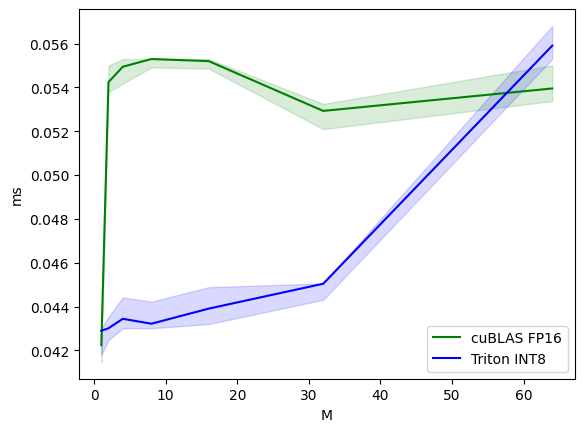

GeMV-performance-FP16 vs INT8:
      M  cuBLAS FP16  Triton INT8
0   1.0     0.042240     0.042896
1   2.0     0.054240     0.043008
2   4.0     0.054944     0.043440
3   8.0     0.055296     0.043216
4  16.0     0.055200     0.043904
5  32.0     0.052928     0.045040
6  64.0     0.053952     0.055904


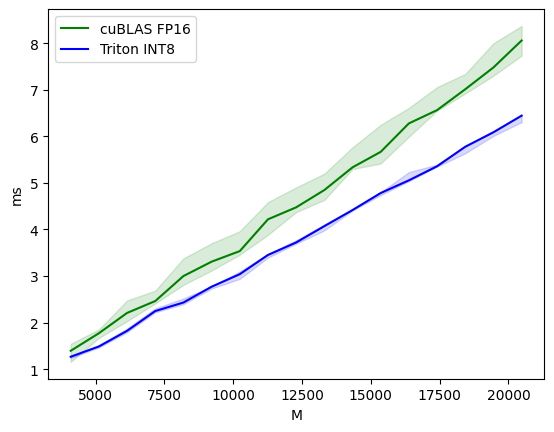

GeMM-performance-FP16 vs INT8:
          M  cuBLAS FP16  Triton INT8
0    4096.0     1.394160     1.266784
1    5120.0     1.771584     1.486848
2    6144.0     2.207472     1.823072
3    7168.0     2.462720     2.248144
4    8192.0     2.999392     2.431008
5    9216.0     3.308192     2.770528
6   10240.0     3.535264     3.039824
7   11264.0     4.217824     3.452160
8   12288.0     4.474880     3.720928
9   13312.0     4.845984     4.070800
10  14336.0     5.333280     4.415872
11  15360.0     5.666176     4.782080
12  16384.0     6.277120     5.054464
13  17408.0     6.561968     5.356512
14  18432.0     7.010336     5.775200
15  19456.0     7.478016     6.086944
16  20480.0     8.056800     6.442976


In [21]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["cublas fp16", "triton int8"],  # Label name for the lines
        line_names=["cuBLAS FP16", "Triton INT8"],  # Line styles
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMV-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["cublas fp16", "triton int8"],  # Label name for the lines
        line_names=["cuBLAS FP16", "Triton INT8"],  # Line styles
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMM-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark_quant_gemm).run(show_plots=True, print_data=True)

In [22]:
provider_funcs = {
    "torch": lambda a, b: quantize_int8(a),
    "triton": lambda a, b: quantize_int8_perrow(a)
}

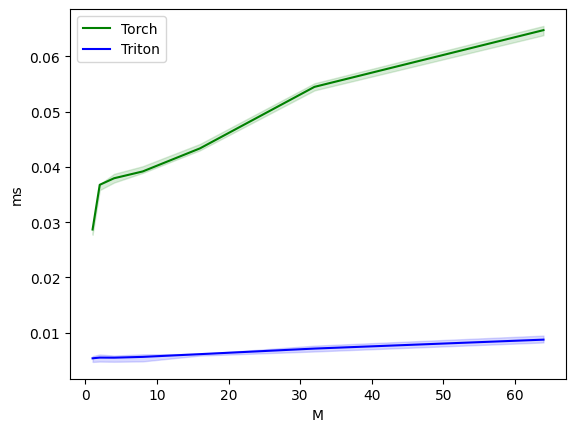

Quantize-performance-decoding:
      M     Torch    Triton
0   1.0  0.028672  0.005360
1   2.0  0.036768  0.005488
2   4.0  0.037952  0.005472
3   8.0  0.039184  0.005616
4  16.0  0.043360  0.006112
5  32.0  0.054496  0.007120
6  64.0  0.064768  0.008736


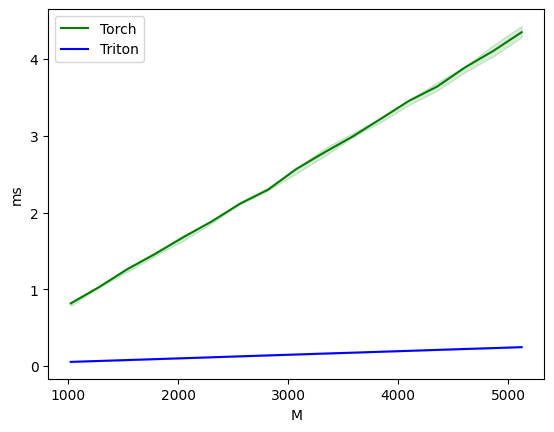

Quantize-performance-prefill:
         M     Torch    Triton
0   1024.0  0.817152  0.054848
1   1280.0  1.027648  0.066816
2   1536.0  1.260368  0.078656
3   1792.0  1.462272  0.090624
4   2048.0  1.679520  0.102624
5   2304.0  1.884160  0.114752
6   2560.0  2.113536  0.126976
7   2816.0  2.297888  0.139168
8   3072.0  2.566176  0.150992
9   3328.0  2.783648  0.163216
10  3584.0  2.990112  0.174656
11  3840.0  3.220864  0.186896
12  4096.0  3.455200  0.198752
13  4352.0  3.641312  0.210976
14  4608.0  3.893248  0.222976
15  4864.0  4.107520  0.234608
16  5120.0  4.350032  0.246944


In [23]:
def benchmark(M, provider, provider_funcs):
    K = 4096  
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(
        lambda: provider_funcs[provider](a, None),
        quantiles=quantiles,
    )
    return ms, max_ms, min_ms


configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(7)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("decoding"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(4, 21)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("prefill"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)

---

# Final Submit (full points)

In [24]:
import torch

import triton
import triton.language as tl


def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 16},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 16},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 16},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 16},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 16},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 16},
                      num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16},
                      num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16},
                      num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8},
                      num_stages=3, num_warps=4),
    ]


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")


@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
    ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
        fpa_ptr, a_ptr, as_ptr,
        M, K,
        stride_fpam, stride_fpak,
        stride_am, stride_ak,
        stride_asm,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid_m = tl.program_id(axis=0)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak

    a_max = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(
            fpa_ptrs,
            mask=offs_k[None, :] < (K - k * BLOCK_SIZE_K),
            other=0.0,
        )
        a_max = tl.maximum(a_max, tl.max(tl.abs(fpa), axis=1))
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak

    a_scale = a_max / 127.0

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(
            fpa_ptrs,
            mask=offs_k[None, :] < (K - k * BLOCK_SIZE_K),
            other=0.0,
        )
        inta = (fpa / a_scale[:, None]).to(tl.int8)
        tl.store(a_ptrs, inta, mask=offs_k[None, :] < (K - k * BLOCK_SIZE_K))
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
        a_ptrs += BLOCK_SIZE_K * stride_ak

    as_offs = pid_m * BLOCK_SIZE_M * stride_asm + tl.arange(0, BLOCK_SIZE_M)
    tl.store(as_ptr + as_offs, a_scale)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale


def quantize_int8(weight, axis=0, tp_rank=0):
    # Weight shape: [H1, H2]
    # Scale shape: [H2] (или [H1], если axis=1)
    INT8_MAX = 127.0

    scale = weight.abs().amax(dim=axis, keepdim=True) / INT8_MAX

    weight = (weight / scale).to(torch.int8)

    # col major will accelerate i8xi8 kernel.
    if axis == 0:
        weight = weight.t().contiguous().t()
    scale = scale.squeeze(axis)
    return weight.contiguous().cuda(tp_rank), scale.contiguous().cuda(tp_rank)


@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def perrow_w8a8_matmul_kernel(
        # Pointers to matrices
        a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # Strides
        stride_am, stride_ak,
        stride_asm,
        stride_bk, stride_bn,
        stride_bsn,
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
        GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """
    C = A x B, A/B в int8 с per-row/per-col scale, C в fp16.
    A: [M, K], scales per-row (M)
    B: [K, N], scales per-col (N)
    """
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)

    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # offs по M/N/K
    offs_am = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_bn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)

    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    as_ptrs = as_ptr + offs_am * stride_asm
    bs_ptrs = bs_ptr + offs_bn * stride_bsn

    a_scale = tl.load(as_ptrs, mask=offs_am < M, other=0.0)
    b_scale = tl.load(bs_ptrs, mask=offs_bn < N, other=0.0)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        k_remaining = K - k * BLOCK_SIZE_K * SPLIT_K
        k_mask = offs_k < k_remaining

        a = tl.load(
            a_ptrs,
            mask=k_mask[None, :] & (offs_am[:, None] < M),
            other=0,
        )
        b = tl.load(
            b_ptrs,
            mask=k_mask[:, None] & (offs_bn[None, :] < N),
            other=0,
        )

        accumulator += tl.dot(a, b, out_dtype=tl.int32)

        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk

    a_scale_f32 = a_scale[:, None].to(tl.float32)
    b_scale_f32 = b_scale[None, :].to(tl.float32)
    c = accumulator.to(tl.float32) * a_scale_f32 * b_scale_f32
    c = c.to(c_ptr.dtype.element_ty)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out is None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    perrow_w8a8_matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )
    return c


def matmul_quantize_int8(fpa, b, b_scale, out=None):
    a, a_scale = quantize_int8_perrow(fpa)
    return matmul_int8(a, a_scale, b, b_scale, out=out)

### Output 

In [25]:
'''
Input Notebook:  tests.ipynb
Output Notebook: notebook_out.ipynb
Executing notebook with kernel: python3
Executing Cell 1---------------------------------------
Ending Cell 1------------------------------------------
Executing Cell 2---------------------------------------
Ending Cell 2------------------------------------------
Executing Cell 3---------------------------------------
torch version: 2.5.1+cu124
triton version: 3.1.0

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Ending Cell 3------------------------------------------
Executing Cell 4---------------------------------------
Ending Cell 4------------------------------------------
Executing Cell 5---------------------------------------
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Ending Cell 5------------------------------------------
Executing Cell 6---------------------------------------
Ending Cell 6------------------------------------------
Executing Cell 7---------------------------------------
To 
accomplish 
the 
task 
...
...
...
'date': 
'

Ending Cell 7------------------------------------------
Executing Cell 8---------------------------------------
Ending Cell 8------------------------------------------
Executing Cell 9---------------------------------------
Ending Cell 9------------------------------------------
Executing Cell 10--------------------------------------
Ending Cell 10-----------------------------------------
Executing Cell 11--------------------------------------
torch.Size([1, 700, 2048])
Ending Cell 11-----------------------------------------
Executing Cell 12--------------------------------------
Ending Cell 12-----------------------------------------
Executing Cell 13--------------------------------------
Ending Cell 13-----------------------------------------
Executing Cell 14--------------------------------------
Ending Cell 14-----------------------------------------
Executing Cell 15--------------------------------------
Ending Cell 15-----------------------------------------
Executing Cell 16--------------------------------------
Ending Cell 16-----------------------------------------
Executing Cell 17--------------------------------------
Ending Cell 17-----------------------------------------
Executing Cell 18--------------------------------------
Ending Cell 18-----------------------------------------
Executing Cell 19--------------------------------------
Ending Cell 19-----------------------------------------
Executing Cell 20--------------------------------------
Ending Cell 20-----------------------------------------
Executing Cell 21--------------------------------------
Ending Cell 21-----------------------------------------
Executing Cell 22--------------------------------------
Ending Cell 22-----------------------------------------
Executing Cell 23--------------------------------------
Ending Cell 23-----------------------------------------
Executing Cell 24--------------------------------------
Ending Cell 24-----------------------------------------
Executing Cell 25--------------------------------------
✅ Triton FP8 and Torch match

Ending Cell 25-----------------------------------------
Executing Cell 26--------------------------------------
Ending Cell 26-----------------------------------------
Executing Cell 27--------------------------------------
Ending Cell 27-----------------------------------------
Executing Cell 28--------------------------------------
Ending Cell 28-----------------------------------------
Executing Cell 29--------------------------------------
M: 16384 K: 2048 N: 6144

Triton time cost: 6.450175523757935 (tflops 32.72875780750839) + quant: 0.19757771492004395 (bandwidth 173.9049284070562)

Torch time cost: 10.030906200408936 (tflops 21.04557936394478)
M: 16384 K: 2048

Torch time cost: 0.0023004384711384773
Triton time cost: 0.00038492027670145035
M: 16384 K: 2048 N: 2048

Triton time cost: 2.2347829341888428 (tflops 31.487954870751544) + quant: 0.1971132755279541 (bandwidth 174.3146841630522)

Torch time cost: 3.029482126235962 (tflops 23.227977999360238)
M: 16384 K: 2048

Torch time cost: 0.0023196199908852577
Triton time cost: 0.0003849640488624573
M: 16384 K: 2048 N: 22016

Triton time cost: 24.165784120559692 (tflops 31.303101779606887) + quant: 0.1983027458190918 (bandwidth 173.26910036508423)

Torch time cost: 43.49111866950989 (tflops 17.39352822028509)
M: 16384 K: 11008 N: 2048

Triton time cost: 11.425265550613403 (tflops 33.104876055562436) + quant: 1.449833631515503 (bandwidth 127.38261115859981)

Torch time cost: 21.530807495117188 (tflops 17.567014151267685)
M: 16384 K: 11008

Torch time cost: 0.012872415594756603
Triton time cost: 0.002822798676788807
Triton time 44.27600812911987 Torch time 78.08231449127197 Quant time 2.0428273677825928
M: 32 K: 2048 N: 6144

Triton time cost: 0.04047560691833496 (tflops 10.186798711824268) + quant: 0.026792049407958984 (bandwidth 2.504805174779362)
Torch time cost: 0.06097817420959473 (tflops 6.761712133242638)
M: 32 K: 2048
Torch time cost: 5.84237277507782e-05
Triton time cost: 4.9126334488391876e-05
M: 32 K: 2048 N: 2048

Triton time cost: 0.03261542320251465 (tflops 4.213925191729643) + quant: 0.0254971981048584 (bandwidth 2.6320093574208316)
Torch time cost: 0.02061915397644043 (tflops 6.665596155353347)
M: 32 K: 2048
Torch time cost: 5.632173269987106e-05
Triton time cost: 5.220063030719757e-05
M: 32 K: 2048 N: 22016

Triton time cost: 0.15709686279296875 (tflops 9.404826573596782) + quant: 0.027443885803222656 (bandwidth 2.4453120261898045)

Torch time cost: 0.22287797927856445 (tflops 6.629047672661205)
M: 32 K: 11008 N: 2048

Triton time cost: 0.10439610481262207 (tflops 7.076263776679558) + quant: 0.026423215866088867 (bandwidth 13.651258265763541)
Torch time cost: 0.10260391235351562 (tflops 7.199865560357338)
M: 32 K: 11008
Torch time cost: 5.988311022520065e-05
Triton time cost: 5.011819303035736e-05
Triton time 0.33458399772644043 Torch time 0.40707921981811523 Quant time 0.1061563491821289

Ending Cell 29-----------------------------------------
'''

"\nInput Notebook:  tests.ipynb\nOutput Notebook: notebook_out.ipynb\nExecuting notebook with kernel: python3\nExecuting Cell 1---------------------------------------\nEnding Cell 1------------------------------------------\nExecuting Cell 2---------------------------------------\nEnding Cell 2------------------------------------------\nExecuting Cell 3---------------------------------------\ntorch version: 2.5.1+cu124\ntriton version: 3.1.0\n\n/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html\n  from .autonotebook import tqdm as notebook_tqdm\n\nEnding Cell 3------------------------------------------\nExecuting Cell 4---------------------------------------\nEnding Cell 4------------------------------------------\nExecuting Cell 5---------------------------------------\n`torch_dtype` is deprecated! Use `dtype` instead!\n\n\nLoading checkpoint 